# DESeq2: Basic Differential Expression (DE) analysis

## Objective: Carry out a basic set of DE analyses using DESeq2 and visualize the results

### Load packages

In [1]:
library(tidyverse)
library(DESeq2)
library(dendextend)
library(RColorBrewer)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.2     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    com

## Load the 2019 pilot dds object from image file

In [2]:

curdir <- "/home/jovyan/work/scratch/analysis_output"
imgdir <- file.path(curdir, "img")

imgfile <- file.path(imgdir, "pilotdds2019.RData")

imgfile

attach(imgfile)

tools::md5sum(imgfile)

### List the objects that have been attached
ls(2)

dds2019 <- dds2019

detach(pos = 2)

[1] "/home/jovyan/work/scratch/analysis_output/img/pilotdds2019.RData"

/home/jovyan/work/scratch/analysis_output/img/pilotdds2019.RData 
                              "6632de5c8a2eed06d8c40c958e6f5d03"

[1] "dds2019"

### Check dimensions of the two objects

### Inspect object & Slots of an S4 class

Let's has a look at the object we have created.

In [3]:
dds2019

class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(1): counts
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(22): Label sample_year ... RIN_normal_threshold
  RIN_lowered_threshold

see the class of dds object

In [4]:
class(dds2019)

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"

DESeqDataSet is a S4 object. Recall that a S4 object was taught when introducing bioconductor. Note that S4 objects allow users to wrap up multiple elements into a single variables where each element is called a slot.

In [5]:
slotNames(dds2019)

[1] "design"             "dispersionFunction" "rowRanges"         
[4] "colData"            "assays"             "NAMES"             
[7] "elementMetadata"    "metadata"

The metadata (columnData) is stored in the slot `colData`

In [6]:
dds2019@colData %>% as.data.frame %>% head(3)

,Label,sample_year,group,enrich_rep,RNA_sample_num,genotype,condition,libprep_person,enrichment_method,enrichment_short,⋯,i5_primer,i7_primer,library_num,bio_replicate,Nanodrop_260_280,Nanodrop_260_230,Nanodrop_concentration_ng_ul,Bioanalyzer_concentration_ng_ul,RIN_normal_threshold,RIN_lowered_threshold
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1_2019_P_M1,1_2019_P_M1,2019,P,1,1,WT,pH4,C,mRNA,M,⋯,i501,i701,1,1,2.14,1.52,293,197,N/A,9.8
2_2019_P_M1,2_2019_P_M1,2019,P,1,2,WT,pH4,C,mRNA,M,⋯,i502,i701,2,2,2.12,1.79,290,225,N/A,9.9
3_2019_P_M1,3_2019_P_M1,2019,P,1,3,WT,pH4,C,mRNA,M,⋯,i503,i701,3,3,2.11,2.49,302,241,N/A,9.9


The design formula is stored in the slot `design`. The design holds the R formula which expresses how the counts depend on the variables in colData.

In [7]:
dds2019@design

~condition + genotype

The first thing you may want to do is **have a look at the raw counts** you have imported. The `DESeq2::counts` function extracts a matrix of counts (with the genes along the rows and samples along the columns). Let us first verify the dimension of this matrix.

In [8]:
dim(counts(dds2019))

[1] 8499   24

In [9]:
head(counts(dds2019),3)

,1_2019_P_M1,2_2019_P_M1,3_2019_P_M1,4_2019_P_M1,5_2019_P_M1,6_2019_P_M1,7_2019_P_M1,8_2019_P_M1,9_2019_P_M1,10_2019_P_M1,⋯,15_2019_P_M1,16_2019_P_M1,17_2019_P_M1,18_2019_P_M1,19_2019_P_M1,20_2019_P_M1,21_2019_P_M1,22_2019_P_M1,23_2019_P_M1,24_2019_P_M1
CNAG_00001,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,158,204,149,176,161,148,172,169,124,119,⋯,216,224,234,338,191,201,192,166,202,235
CNAG_00003,201,156,161,171,162,103,172,170,175,131,⋯,197,195,211,201,118,133,109,113,154,169


This slot returns gene specific information (it will be populated later)

In [10]:
dds2019@dispersionFunction

function () 
NULL
<bytecode: 0x55eb022b7868>

## Estimate Size Factors and Dispersion Parameters

You recall that DESeq requires that  we have estimates for sample specific size factors and gene specific dispersion factors. More specifically, recall that DESeq models the count $K_{ij}$ (gene $i$, sample $j$) as negative binomial with mean $\mu_{ij}$ and dispersion parameter $\alpha_i$. Here $\mu_{ij}=s_j q_{ij}$ where $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} z_j$. Here $s_j$ is the sample $j$ specific size factor.

**Summarize of notation**
- $K_{ij}$ denotes the observed **number of reads** mapped to gene $i$ for sample $j$
- $K_{ij}$ follows a **negative binomial distribution** with
    - **Mean** $\mu_{ij}$
    - **Dispersion parameter** $\alpha_i$
- Modelling
    - $K_{ij} \sim NB(\mu_{ij}, \alpha_i)$
    - $\mu_{ij} = s_{j}q_{ij}$
        - $s_j$ is sample $j$ specific normalization constant
    - $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} z_j$

### 01 Size Factors
 We begin by estimating the size factors $s_1,\ldots,s_n$:

In [11]:
dds2019 <- estimateSizeFactors(dds2019)

Now, compare the dds object to that of before applying the estimateSizeFactors() function. What has changed? What remains unchanged?

In [12]:
dds2019

class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(1): counts
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor

Note that there is a **sizeFactor** added to **colData**. Let's look at it more carefully

```
> dds # (before estimateSizeFactors)
class: DESeqDataSet 
class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(1): counts
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(22): Label sample_year ... RIN_normal_threshold
  RIN_lowered_threshold

> dds # (after estimateSizeFactors)
class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(1): counts
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor

You can also get the size factors directly

In [13]:
sizeFactors(dds2019)

1_2019_P_M1  2_2019_P_M1  3_2019_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
   1.5916393    1.6587110    1.5128946    1.4196686    1.4373847    1.2371000 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 
   1.4014829    1.4421725    1.1744409    1.0763647    1.0421627    0.9712383 
13_2019_P_M1 14_2019_P_M1 15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 
   0.7709868    0.7523820    0.7176796    0.8978403    0.8936416    0.9316181 
19_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
   0.7494357    0.7755715    0.5838325    0.6343998    0.7551861    0.8088364

 It is preferable to limit the number of decimal places. Next show the size factors rounded to 3 decimal places

In [14]:
round(sizeFactors(dds2019),3)

1_2019_P_M1  2_2019_P_M1  3_2019_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
       1.592        1.659        1.513        1.420        1.437        1.237 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 
       1.401        1.442        1.174        1.076        1.042        0.971 
13_2019_P_M1 14_2019_P_M1 15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 
       0.771        0.752        0.718        0.898        0.894        0.932 
19_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
       0.749        0.776        0.584        0.634        0.755        0.809

Summarize size factors

In [15]:
summary(sizeFactors(dds2019))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5838  0.7670  0.9514  1.0515  1.4060  1.6587 

Do you see a trend?

In [16]:
sizeFactors(dds2019) %>%
    as.data.frame %>%
        rownames_to_column %>%
            mutate(libnum = as.integer(str_remove(rowname, "_2019_P_M1"))) -> mydf

colnames(mydf)[2] <- "sizefac"

mydf

rowname,sizefac,libnum
<chr>,<dbl>,<int>
1_2019_P_M1,1.5916393,1
2_2019_P_M1,1.6587110,2
3_2019_P_M1,1.5128946,3
4_2019_P_M1,1.4196686,4
5_2019_P_M1,1.4373847,5
6_2019_P_M1,1.2371000,6
7_2019_P_M1,1.4014829,7
8_2019_P_M1,1.4421725,8
9_2019_P_M1,1.1744409,9


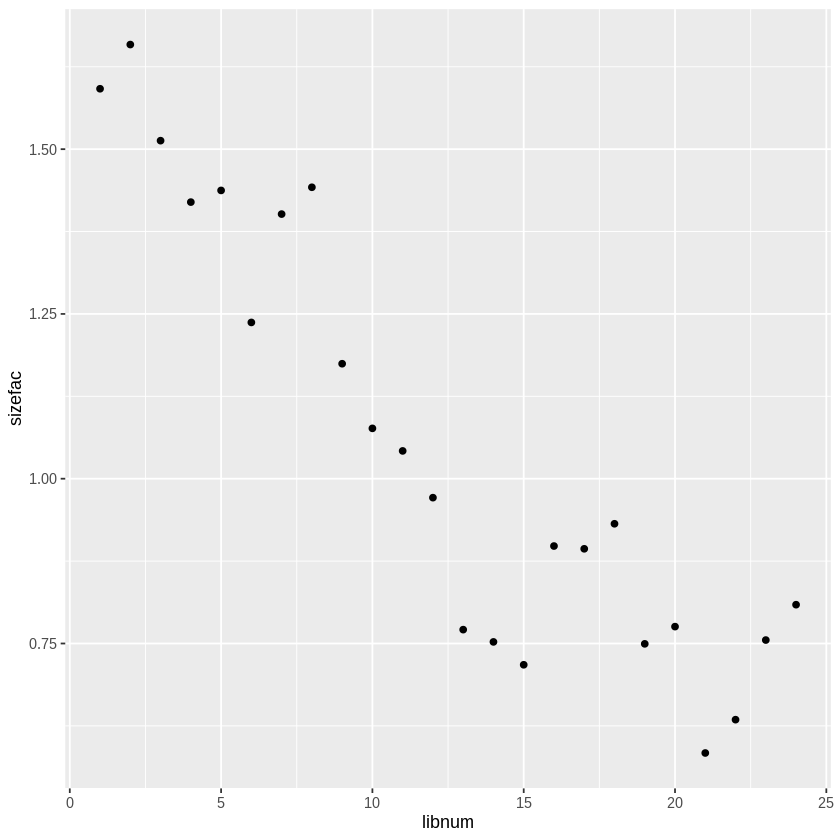

In [17]:
ggplot(mydf, aes(x = libnum, y = sizefac)) + geom_point()

Now that the size factors have been estimated, we can get "normalized" counts (DESeq2 normalizes against size factor)

In [18]:
# original counts for libraries 1 and 24
counts(dds2019)[1:5,c(1,24)]

# normalized count
counts(dds2019, normalize = TRUE)[1:5, c(1,24)]

# Size factor

sizeFactors(dds2019)[c(1,24)]

,1_2019_P_M1,24_2019_P_M1
CNAG_00001,0,0
CNAG_00002,158,235
CNAG_00003,201,169
CNAG_00004,904,523
CNAG_00005,22,40


,1_2019_P_M1,24_2019_P_M1
CNAG_00001,0.00000,0.00000
CNAG_00002,99.26872,290.54083
CNAG_00003,126.28489,208.94213
CNAG_00004,567.96787,646.60789
CNAG_00005,13.82223,49.45376


1_2019_P_M1 24_2019_P_M1 
   1.5916393    0.8088364

In [19]:
# normalized manually using size factors for library 1
counts(dds2019)[1:5, 1] / sizeFactors(dds2019)[1]

CNAG_00001 CNAG_00002 CNAG_00003 CNAG_00004 CNAG_00005 
   0.00000   99.26872  126.28489  567.96787   13.82223

In [20]:
# normalized manually using size factors for library 24
counts(dds2019)[1:5, 24] / sizeFactors(dds2019)[24]

CNAG_00001 CNAG_00002 CNAG_00003 CNAG_00004 CNAG_00005 
   0.00000  290.54083  208.94213  646.60789   49.45376

How do you get the raw counts for gene  "GeneID: CNAG_05845"?

In [21]:
counts(dds2019, normalize = TRUE)["CNAG_05845",]

1_2019_P_M1  2_2019_P_M1  3_2019_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
    1753.538     1483.682     1395.999     1526.413     1540.993     1662.760 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 
    1483.429     1396.504     1611.831     1532.009     1625.466     1693.714 
13_2019_P_M1 14_2019_P_M1 15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 
    1629.081     1600.251     1574.519     1551.501     1732.238     1523.156 
19_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
    1822.705     1799.963     1872.112     1692.939     1832.661     1791.462

### 02 Dispersion Parameters
Next, we get the dispersion factors $\alpha_1,\ldots,\alpha_{m}$

In [22]:
dds2019 <- estimateDispersions(dds2019)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Now inspect the dds object again and note that the rowRanges slot has extra information ("metadata column names(0):" before versus "column names(9): baseMean baseVar ... dispOutlier dispMAP")
- before: 
    - `metadata column names(0):`
- after:  
    - `column names(9): baseMean baseVar ...`

In [23]:
dds2019

class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(2): counts mu
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(10): baseMean baseVar ... dispOutlier dispMAP
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor

Can you notice the difference?
```
> dds (before dispersion)
class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(1): counts
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor
  
> dds (after dispersion)
class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(2): counts mu
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(10): baseMean baseVar ... dispOutlier dispMAP
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor
```

Note that the dispersionfunction slot is now populated

In [24]:
dds2019@dispersionFunction

function (q) 
coefs[1] + coefs[2]/q
<bytecode: 0x55eb0c6101a0>
<environment: 0x55eb0c6107f8>
attr(,"coefficients")
asymptDisp  extraPois 
0.01418035 0.87630661 
attr(,"fitType")
[1] "parametric"
attr(,"varLogDispEsts")
[1] 0.9024663
attr(,"dispPriorVar")
[1] 0.8025493

We can extract the gene specific dispersion factors using dispersions(). Note that there will be one number per gene. We look at the first four genes (rounded to 4 decimal places)

In [25]:
alphas <- dispersions(dds2019)

Verify that the number of dispersion factors equals the number of genes

In [26]:
# number of disperion factors
length(alphas)

[1] 8499

In [27]:
round(alphas[1:4], 4)

[1]     NA 0.0132 0.0231 0.0044

Extract the metadata using mcols() for the first four genes

| Terms       | Description                                   |
|-------------|-----------------------------------------------|
| baseMean    |     mean of normalized counts for all samples |
| baseVar     | variance of normalized counts for all samples |
| allZero     |                all counts for a gene are zero |
| dispGeneEst |             gene-wise estimates of dispersion |
| dispFit     |                   fitted values of dispersion |
| dispersion  |                  final estimate of dispersion |
| dispIter    |                          number of iterations |
| dispOut     |                 dispersion flagged as outlier |
| dispMAP     |                 maximum a posteriori estimate |


In [28]:
mcols(dds2019)[1:4,] %>% as.data.frame

,baseMean,baseVar,allZero,dispGeneEst,dispGeneIter,dispFit,dispersion,dispIter,dispOutlier,dispMAP
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
CNAG_00001,0.0000,0.000,TRUE,NA,NA,NA,NA,NA,NA,NA
CNAG_00002,192.4564,8133.183,FALSE,0.012090962,9,0.01873362,0.013202310,9,FALSE,0.013202310
CNAG_00003,164.9908,3089.489,FALSE,0.023820456,10,0.01949159,0.023065791,7,FALSE,0.023065791
CNAG_00004,571.0547,1819.185,FALSE,0.003107148,5,0.01571489,0.004430586,12,FALSE,0.004430586


Summarize the dispersion factors using a box plot (may want to log transform)

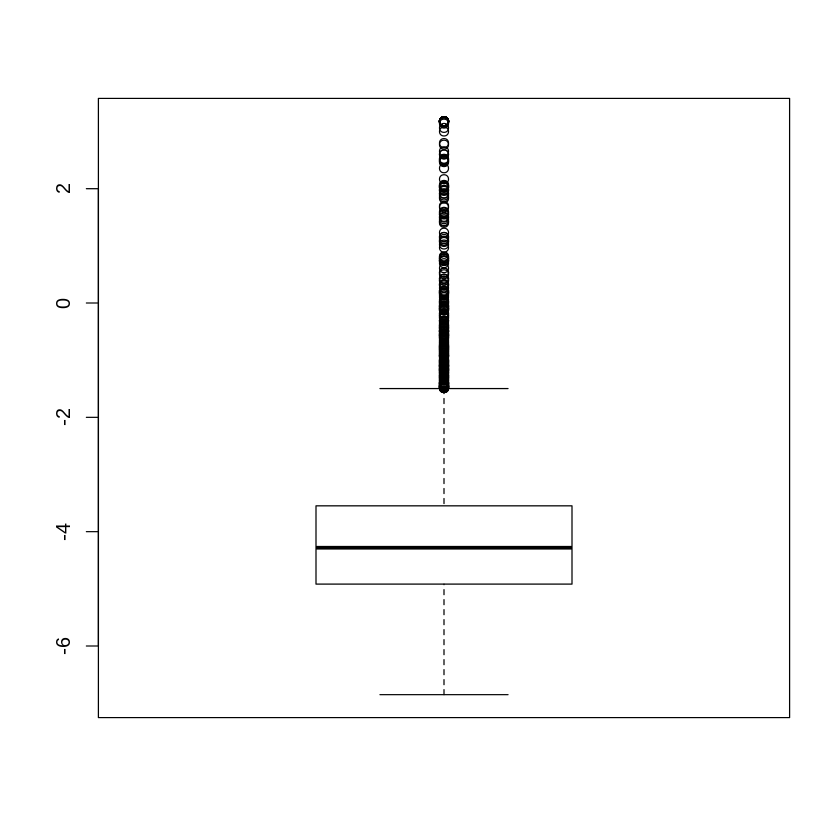

In [29]:
boxplot(log(dispersions(dds2019)))

## Differential Expression Analysis
We can now conduct a differential expression analysis using the DESeq() function. Keep in mind that to get to this step, we first estimated the size factors and then the dispersion parameters.

In [30]:
### Carry out DE analysis
ddsDE <- DESeq(dds2019)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [31]:
### Look at object
ddsDE

class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(4): counts mu H cooks
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(26): baseMean baseVar ... deviance maxCooks
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor

In [32]:
### Look at some of the results
results(ddsDE)

log2 fold change (MLE): genotype WT vs sre1d 
Wald test p-value: genotype WT vs sre1d 
DataFrame with 8499 rows and 6 columns
                        baseMean     log2FoldChange              lfcSE
                       <numeric>          <numeric>          <numeric>
CNAG_00001                     0                 NA                 NA
CNAG_00002      192.456384076694 0.0459290105698189 0.0812849125012254
CNAG_00003      164.990819436254 0.0432979308487266  0.101045100070341
CNAG_00004      571.054651467718 0.0347715410374543 0.0464312203030827
CNAG_00005      28.7106195205257 -0.377056805602812  0.192347436642309
...                          ...                ...                ...
ENSRNA049551942                0                 NA                 NA
ENSRNA049551964                0                 NA                 NA
ENSRNA049551993                0                 NA                 NA
large_MTrRNA    5333.97356461621 -0.396337460272526   0.13434088145007
small_MTrRNA    1705.7

Note that currently, the model we have is an additive model, which does not include the interaction term of `Media` and `Strain`

### Look at some of the results (tidy version)


In [33]:
results(ddsDE, tidy = TRUE)

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CNAG_00001,0.00000,NA,NA,NA,NA,NA
CNAG_00002,192.45638,0.0459290106,0.08128491,0.565037338,5.720484e-01,6.754695e-01
CNAG_00003,164.99082,0.0432979308,0.10104510,0.428501044,6.682864e-01,7.564508e-01
CNAG_00004,571.05465,0.0347715410,0.04643122,0.748882773,4.539279e-01,5.662635e-01
CNAG_00005,28.71062,-0.3770568056,0.19234744,-1.960290255,4.996187e-02,9.433385e-02
CNAG_00006,3147.39964,-0.1313696927,0.04955489,-2.650993457,8.025540e-03,1.995982e-02
CNAG_00007,1484.87545,-0.2511214344,0.08051906,-3.118782455,1.816000e-03,5.492473e-03
CNAG_00008,938.01932,-0.0095775568,0.04760749,-0.201177504,8.405598e-01,8.873725e-01
CNAG_00009,305.19881,-0.1866458870,0.09952871,-1.875296922,6.075189e-02,1.116044e-01


We can get the results for the differential expression analysis using results(). Here, we can compare two group of samples specified by the contrast. (If not, the default contrast would be the last term in your additive model `design(dds)`).

In [34]:
# DE with respect to condition
myres_condition4v8 <- results(ddsDE, contrast = c("condition", "pH4", "pH8"))
myres_condition4v8

log2 fold change (MLE): condition pH4 vs pH8 
Wald test p-value: condition pH4 vs pH8 
DataFrame with 8499 rows and 6 columns
                        baseMean      log2FoldChange              lfcSE
                       <numeric>           <numeric>          <numeric>
CNAG_00001                     0                  NA                 NA
CNAG_00002      192.456384076694   -1.34351851614176 0.0813854454817818
CNAG_00003      164.990819436254  -0.831905577724638  0.101018400723969
CNAG_00004      571.054651467718 -0.0871138906737344 0.0465166816365353
CNAG_00005      28.7106195205257   -1.29275886849841  0.192729463777133
...                          ...                 ...                ...
ENSRNA049551942                0                  NA                 NA
ENSRNA049551964                0                  NA                 NA
ENSRNA049551993                0                  NA                 NA
large_MTrRNA    5333.97356461621  -0.948564278537808  0.134340883270906
small_MTrR

In [35]:
# DE with respect to condition (flip order)
myres_condition8v4 <- results(ddsDE, contrast = c("condition", "pH8", "pH4"))
myres_condition8v4

log2 fold change (MLE): condition pH8 vs pH4 
Wald test p-value: condition pH8 vs pH4 
DataFrame with 8499 rows and 6 columns
                        baseMean     log2FoldChange              lfcSE
                       <numeric>          <numeric>          <numeric>
CNAG_00001                     0                 NA                 NA
CNAG_00002      192.456384076694   1.34351851614176 0.0813854454817818
CNAG_00003      164.990819436254  0.831905577724638  0.101018400723969
CNAG_00004      571.054651467718 0.0871138906737344 0.0465166816365353
CNAG_00005      28.7106195205257   1.29275886849841  0.192729463777133
...                          ...                ...                ...
ENSRNA049551942                0                 NA                 NA
ENSRNA049551964                0                 NA                 NA
ENSRNA049551993                0                 NA                 NA
large_MTrRNA    5333.97356461621  0.948564278537808  0.134340883270906
small_MTrRNA    1705.7

In [36]:
### DE with respect to genotype
myres_strainvWT <- results(ddsDE, contrast = c("genotype", "sre1d", "WT"))
myres_strainvWT

log2 fold change (MLE): genotype sre1d vs WT 
Wald test p-value: genotype sre1d vs WT 
DataFrame with 8499 rows and 6 columns
                        baseMean      log2FoldChange              lfcSE
                       <numeric>           <numeric>          <numeric>
CNAG_00001                     0                  NA                 NA
CNAG_00002      192.456384076694 -0.0459290105698189 0.0812849125012254
CNAG_00003      164.990819436254 -0.0432979308487266  0.101045100070341
CNAG_00004      571.054651467718 -0.0347715410374543 0.0464312203030827
CNAG_00005      28.7106195205257   0.377056805602812  0.192347436642309
...                          ...                 ...                ...
ENSRNA049551942                0                  NA                 NA
ENSRNA049551964                0                  NA                 NA
ENSRNA049551993                0                  NA                 NA
large_MTrRNA    5333.97356461621   0.396337460272526   0.13434088145007
small_MTrR

Let's look at the results for the first four genes

In [37]:
### Tidy the results
myres_condition8v4 <- results(ddsDE, contrast = c("condition", "pH8", "pH4"), tidy = TRUE)
myres_condition8v4

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CNAG_00001,0.00000,NA,NA,NA,NA,NA
CNAG_00002,192.45638,1.343518516,0.08138545,16.5080932,3.208624e-61,2.870856e-60
CNAG_00003,164.99082,0.831905578,0.10101840,8.2351886,1.792750e-16,4.795769e-16
CNAG_00004,571.05465,0.087113891,0.04651668,1.8727452,6.110358e-02,7.489553e-02
CNAG_00005,28.71062,1.292758868,0.19272946,6.7076349,1.978041e-11,4.320208e-11
CNAG_00006,3147.39964,-0.139327775,0.04956000,-2.8112951,4.934250e-03,6.756102e-03
CNAG_00007,1484.87545,-0.747920328,0.08053624,-9.2867544,1.590647e-20,4.927921e-20
CNAG_00008,938.01932,-0.079110196,0.04765929,-1.6599115,9.693226e-02,1.159517e-01
CNAG_00009,305.19881,-0.558838066,0.09968395,-5.6060989,2.069377e-08,3.933651e-08


In [38]:
### Tidy the results for DE with respect to condition
### Results are sorted in ascending order by adjusted p-value
### Here ph4 is the reference level
### log2FC > 0 suggests that higher pH (pH8) is associated with increased expression
### log2FC < 0 suggests that higher pH (pH8) is associated with lower expression
myres_condition8v4 <- results(ddsDE, contrast = c("condition", "pH8", "pH4"), tidy = TRUE)

myres_condition8v4 %>% 
    arrange(desc(-padj)) %>% 
        head(10)

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CNAG_00275,1072.9219,-4.048106,0.10667356,-37.94854,0,0
CNAG_00309,539.1312,-3.331524,0.08444635,-39.45137,0,0
CNAG_00409,1093.4775,-5.030655,0.07452918,-67.49913,0,0
CNAG_00531,15371.8856,3.563691,0.05663035,62.92900,0,0
CNAG_00601,506.4752,4.661577,0.09625726,48.42832,0,0
CNAG_00897,12255.8281,4.856924,0.07970883,60.93332,0,0
CNAG_01272,49334.5209,1.961009,0.04521777,43.36812,0,0
CNAG_01275,2534.1015,2.273088,0.04888985,46.49406,0,0
CNAG_01344,3528.6160,-1.582122,0.04028591,-39.27234,0,0


### Visualize DE effect

Looking at the results for these two genes: 

* The estimated log2FC for CNAG_00275 is negative. We will verify visually that ph8, compared to pH4,  is associated with lower expression

* The estimated log2FC for CNAG_00531 is positive. We will verify visually that ph8, compared to pH4, is associated with higher expression


In [39]:
results(ddsDE, tidy = TRUE) %>%
    filter(row %in% c("CNAG_00275","CNAG_00531"))

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CNAG_00275,1072.922,-0.3268490,0.10536149,-3.102167,0.0019210943,0.005769654
CNAG_00531,15371.886,0.1902424,0.05662427,3.359733,0.0007801794,0.002625616


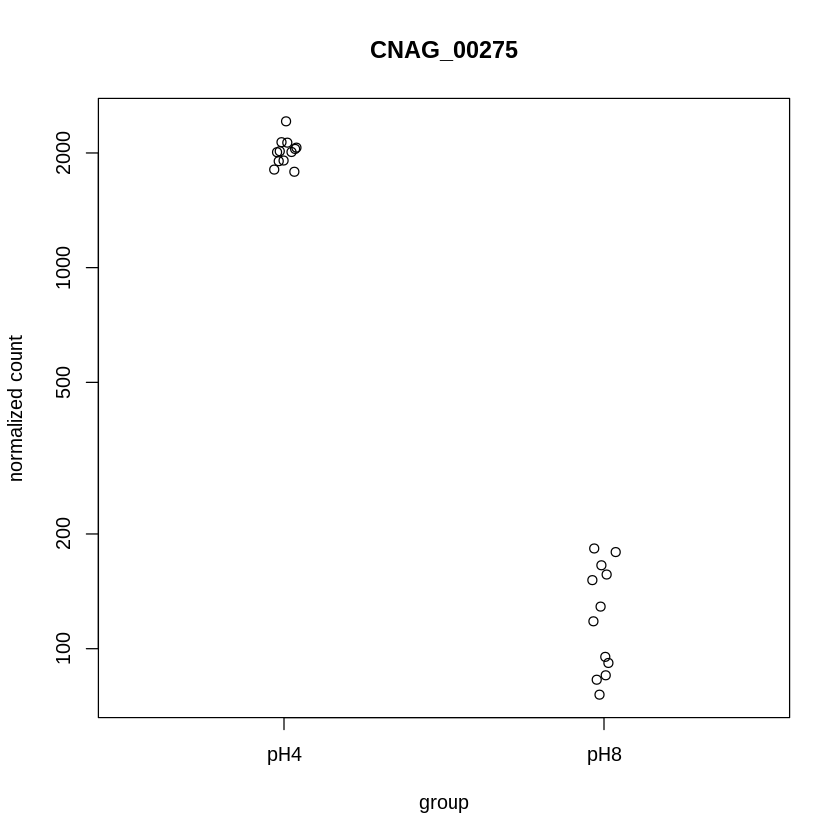

In [40]:
### This dot plot verify visually that exposure to ph8, compared to pH4,  is associated with lower expression
plotCounts(dds2019, "CNAG_00275", intgroup = "condition")

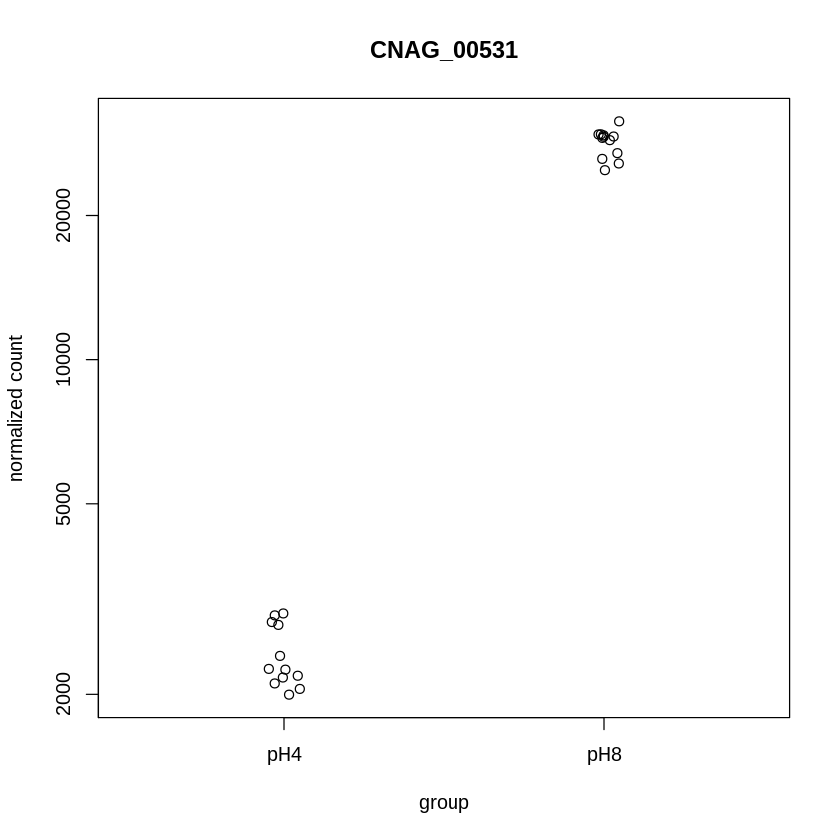

In [41]:
### This dot plot verify visually that exposure to ph8, compared to pH4,  is associated with higher expression
plotCounts(dds2019, "CNAG_00531", intgroup = "condition")

Volcano plot

Warning message:
“Removed 348 rows containing missing values (geom_point).”

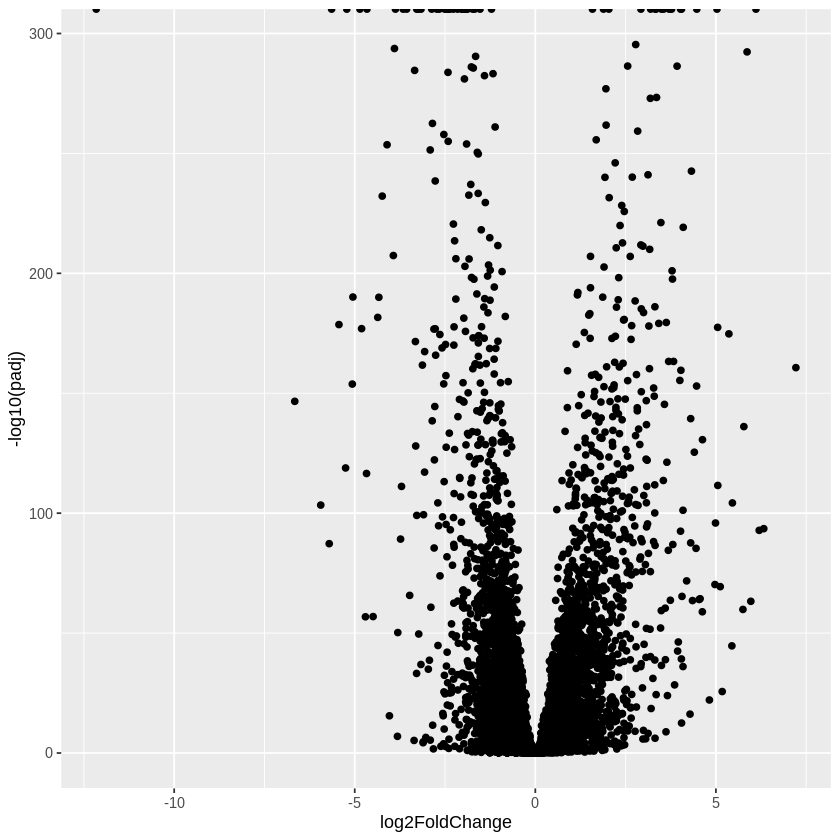

In [42]:
### Volcano plot for con effect
ggplot(results(ddsDE, contrast = c("condition", "pH4", "pH8"), tidy = TRUE), 
       aes(x = log2FoldChange, y = -log10(padj))) + geom_point()

Warning message:
“Removed 348 rows containing missing values (geom_point).”

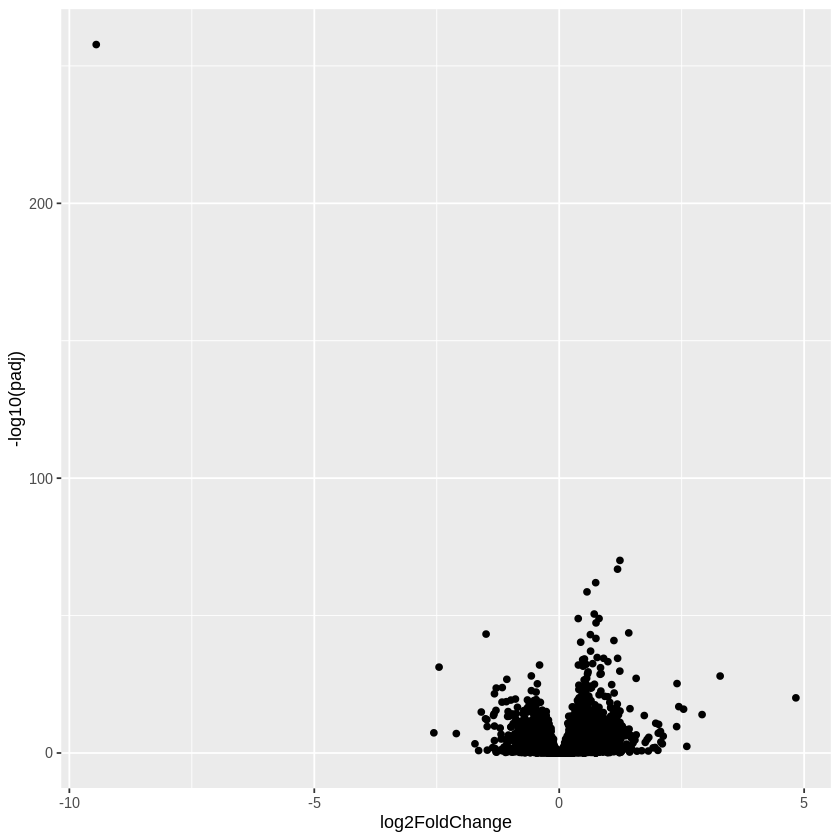

In [43]:
### Genotype Effect
ggplot(results(ddsDE, contrast = c("genotype", "sre1d", "WT"), tidy = TRUE), 
       aes(x = log2FoldChange, y = -log10(padj))) + geom_point()

## Clustering

### Regularized log transformation
The regularized log transform can be obtained using the [rlog() function](https://rdrr.io/bioc/DESeq2/man/rlog.html). Note that an important argument for this function is blind (TRUE by default). The default "blinds" the normalization to the design. This is very important so as to not bias the analyses (e.g. class discovery) 

In [44]:
rld <- rlog(dds2019, blind = TRUE)

### Dendrogram of samples: showing strain & media of each sample

Hierarchical clustering using rlog transformation

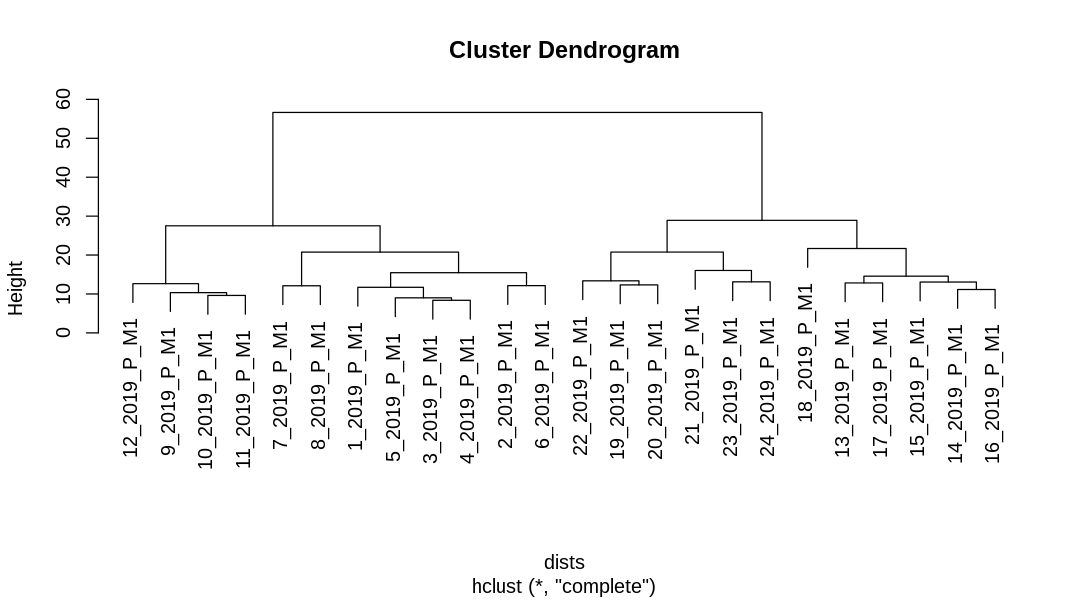

In [45]:
options(repr.plot.width = 9, repr.plot.height = 5)
dists <- dist(t(assay(rld)))
plot(hclust(dists)) 

Store the dendrogram of samples using hierarchical clustering

In [46]:
assay(rld) %>%
    t() %>%
    dist %>%
    hclust(method = "complete") %>%
    as.dendrogram ->
    mydend

Dendrogram of samples: showing strain of each sample

In [47]:

dendplot <- function(mydend, columndata, labvar, colvar, pchvar) {
    cols <- factor(columndata[[colvar]][order.dendrogram(mydend)])
    collab <- brewer.pal(max(3,nlevels(cols)),"Set1")[cols]
    pchs <- factor(columndata[[pchvar]][order.dendrogram(mydend)])
    pchlab <- seq_len(nlevels(pchs))[pchs]
    lablab <- columndata[[labvar]][order.dendrogram(mydend)]
    
    mydend %>% 
        set("labels_cex",1) %>% 
        set("labels_col",collab) %>%
        set("leaves_pch",pchlab) %>%
        set("labels", lablab)
}



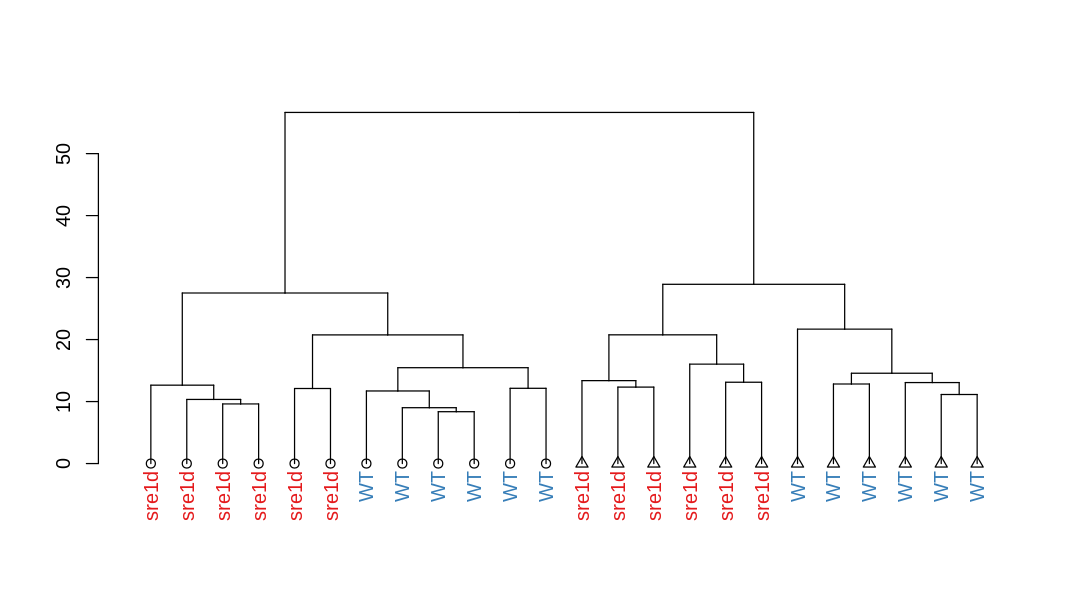

In [48]:
options(repr.plot.width = 9, repr.plot.height = 5)
dendplot(mydend, dds2019@colData, 
         "genotype",    # variable that show in label
         "genotype",    # variable that define color
         "condition") %>% # variable that define shape of points
    plot

Dendrogram of samples: showing media of each sample

### Customize presentation

In [49]:
### Merge gene expression with meta data
myDEplotData <- function(mydds, geneid, mergelab) {
    counts(mydds, normalize = TRUE) %>%
        as_tibble(rownames="gene") %>%
        filter(gene == geneid) %>%
        gather(Label, geneexp, -gene) %>%
        select(-gene) -> genedat

    colData(mydds) %>%
        as.data.frame %>%
        as_tibble %>%
        full_join(genedat, by = mergelab) -> genedat
    
    return(genedat)
}

myDEplotData(dds2019, "CNAG_00003", "Label")[,c("Label", "genotype", "condition" , "geneexp")]


Label,genotype,condition,geneexp
<chr>,<fct>,<fct>,<dbl>
1_2019_P_M1,WT,pH4,126.28489
2_2019_P_M1,WT,pH4,94.04893
3_2019_P_M1,WT,pH4,106.41852
4_2019_P_M1,WT,pH4,120.45064
5_2019_P_M1,WT,pH4,112.70469
6_2019_P_M1,WT,pH4,83.25923
7_2019_P_M1,sre1d,pH4,122.72715
8_2019_P_M1,sre1d,pH4,117.87771
9_2019_P_M1,sre1d,pH4,149.00707


In [50]:
### Basic function

myDEplot <- function(mydds, geneid, mergelab) {
    mydat <- myDEplotData(mydds, geneid, mergelab)
    ggplot(mydat, aes(x = condition, y = geneexp))+ geom_point()
}



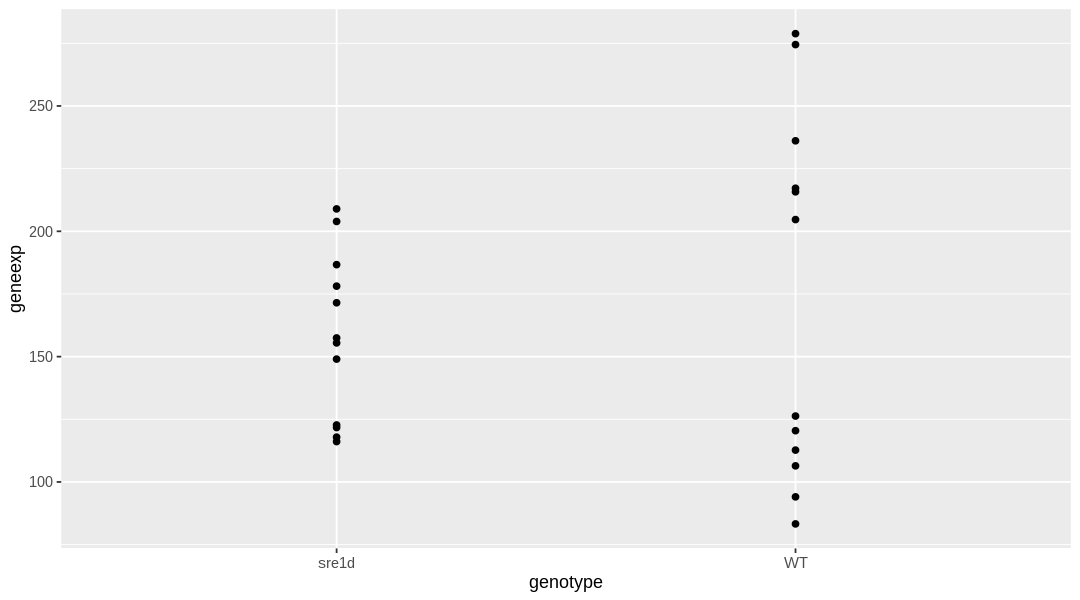

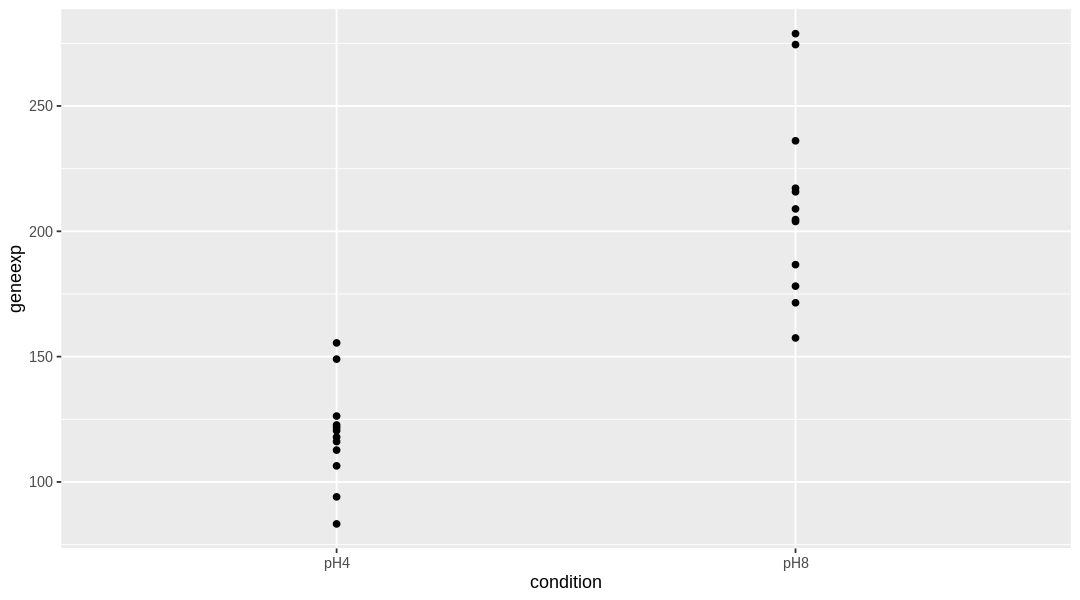

In [51]:
### Allow for grouping by any factor in dataframe

myDEplot <- function(mydds, geneid, grpvar, mergelab) {
    mydat <- myDEplotData(mydds, geneid, mergelab)
    ggplot(mydat, aes_string(x=grpvar, y = "geneexp"))+ geom_point()
}

myDEplot(dds2019, "CNAG_00003", "genotype", "Label")
myDEplot(dds2019, "CNAG_00003", "condition", "Label")

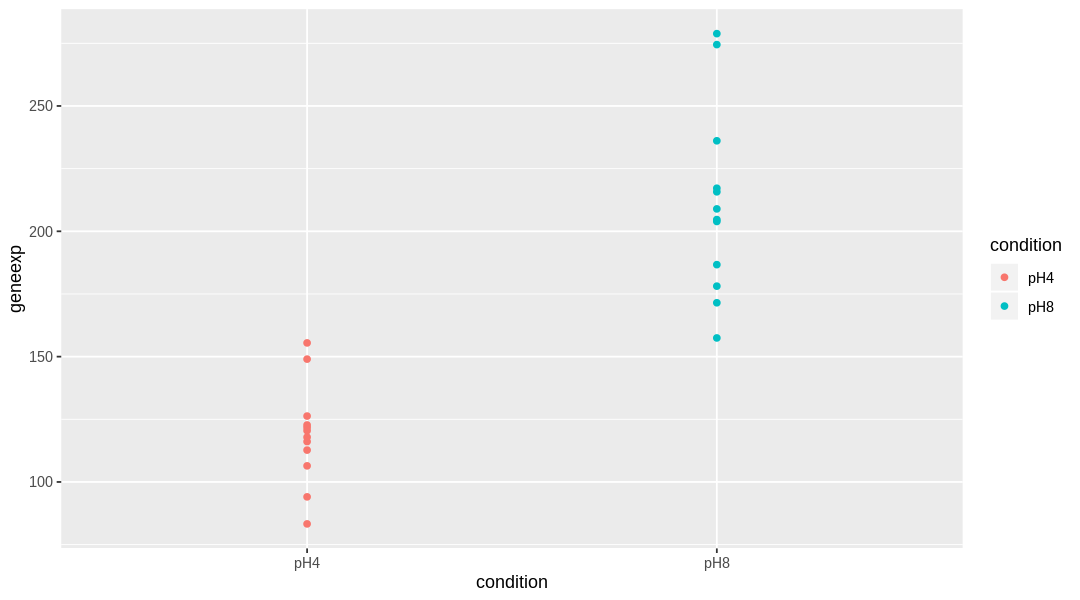

In [52]:
### Add color

myDEplot <- function(mydds, geneid, grpvar, mergelab) {
    mydat <- myDEplotData(mydds, geneid, mergelab)
    ggplot(mydat, aes_string(x=grpvar, y = "geneexp", col = grpvar))+ geom_point()
}
myDEplot(dds2019, "CNAG_00003", "condition", "Label")

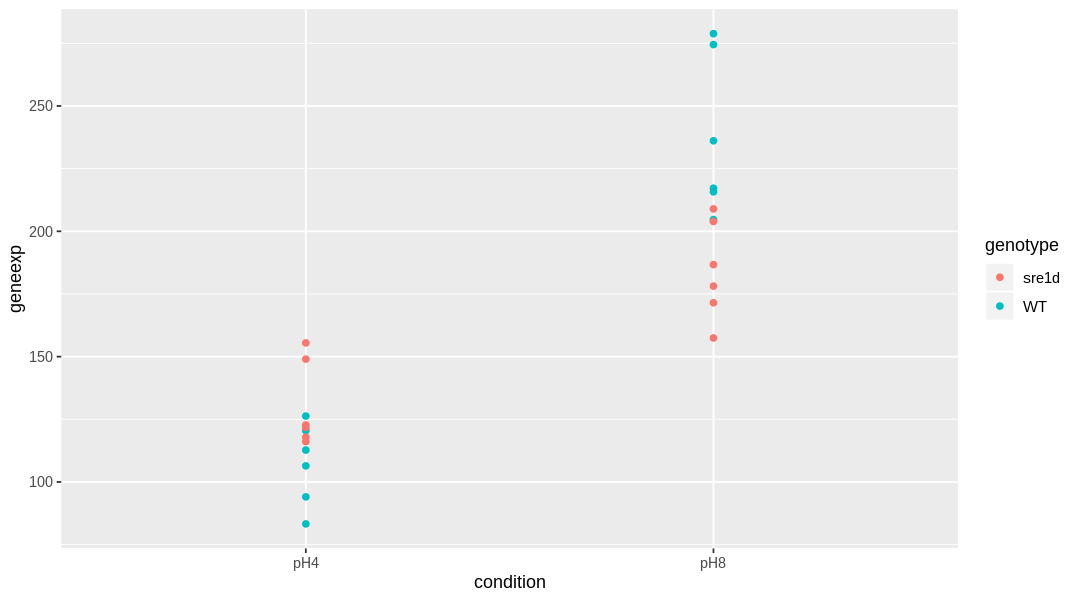

In [53]:
### Alow for coloring with respect to another factor
myDEplot <- function(mydds, geneid, grpvar, colvar, mergelab) {
    mydat <- myDEplotData(mydds, geneid, mergelab)
    ggplot(mydat, aes_string(x=grpvar, y = "geneexp", col = colvar))+ geom_point()
}
myDEplot(dds2019, "CNAG_00003", "condition", "genotype", "Label")

In [54]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 9 (stretch)

Matrix products: default
BLAS:   /usr/lib/openblas-base/libblas.so.3
LAPACK: /usr/lib/libopenblasp-r0.2.19.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] RColorBrewer_1.1-2          dendextend_1.12.0          
 [3] DESeq2_1.24.0               SummarizedExperiment_1.14.0
 [5] DelayedArray_0.10.0         BiocParallel_1.18.0        
 [7] matrixStats_0.54.0          Biobase_2.44.0             
 [9] GenomicRanges_1.